In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
import os

# -------------------------
# Device Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Transforms (Resize & Normalize for EfficientNet)
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNetB0 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------
# Dataset and Dataloader
# -------------------------
train_dir = r'D:\Rice-Disease-Simulation\data\train'
val_dir = r'D:\Rice-Disease-Simulation\data\validation'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# -------------------------
# Load EfficientNet-B0
# -------------------------
model = efficientnet_b0(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier (head)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

# -------------------------
# Loss and Optimizer
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# -------------------------
# Training Loop
# -------------------------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}")

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/10] Train Loss: 105.0481, Train Acc: 0.4457
Validation Accuracy: 0.6856
[2/10] Train Loss: 87.8061, Train Acc: 0.6695
Validation Accuracy: 0.7254
[3/10] Train Loss: 75.2231, Train Acc: 0.7300
Validation Accuracy: 0.7708
[4/10] Train Loss: 66.4186, Train Acc: 0.7476
Validation Accuracy: 0.7708
[5/10] Train Loss: 59.9450, Train Acc: 0.7648
Validation Accuracy: 0.7784
[6/10] Train Loss: 55.4174, Train Acc: 0.7881
Validation Accuracy: 0.7917
[7/10] Train Loss: 51.4441, Train Acc: 0.7824
Validation Accuracy: 0.7860
[8/10] Train Loss: 48.2469, Train Acc: 0.8005
Validation Accuracy: 0.8030
[9/10] Train Loss: 45.6127, Train Acc: 0.8052
Validation Accuracy: 0.8144
[10/10] Train Loss: 43.4428, Train Acc: 0.8100
Validation Accuracy: 0.8087


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Validation Accuracy: 0.8087


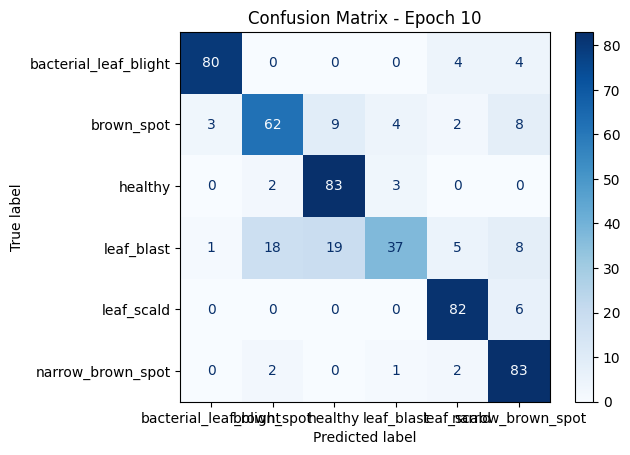

In [3]:
# Validation
model.eval()
val_correct, val_total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc = val_correct / val_total
print(f"Validation Accuracy: {val_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Epoch {epoch+1}')
plt.show()

In [4]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.95      0.91      0.93        88
           brown_spot       0.74      0.70      0.72        88
              healthy       0.75      0.94      0.83        88
           leaf_blast       0.82      0.42      0.56        88
           leaf_scald       0.86      0.93      0.90        88
    narrow_brown_spot       0.76      0.94      0.84        88

             accuracy                           0.81       528
            macro avg       0.81      0.81      0.80       528
         weighted avg       0.81      0.81      0.80       528



In [5]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [6]:
target_layer = model.features[-1]  # or model.features[18] usually
cam_extractor = GradCAM(model, target_layer=target_layer)

In [7]:
# Helper to unnormalize a tensor image
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

# Create denormalizer instance using ImageNet stats (used in your transform)
denormalize = Denormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

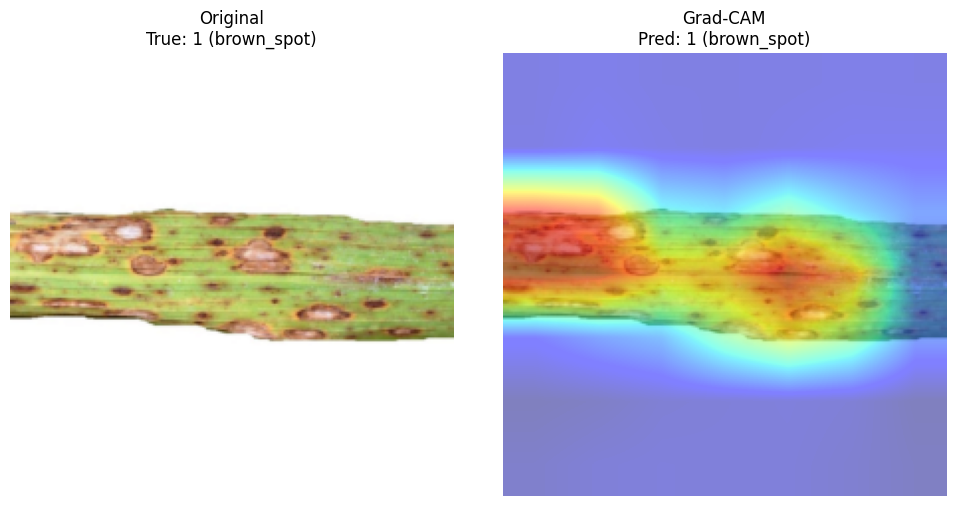

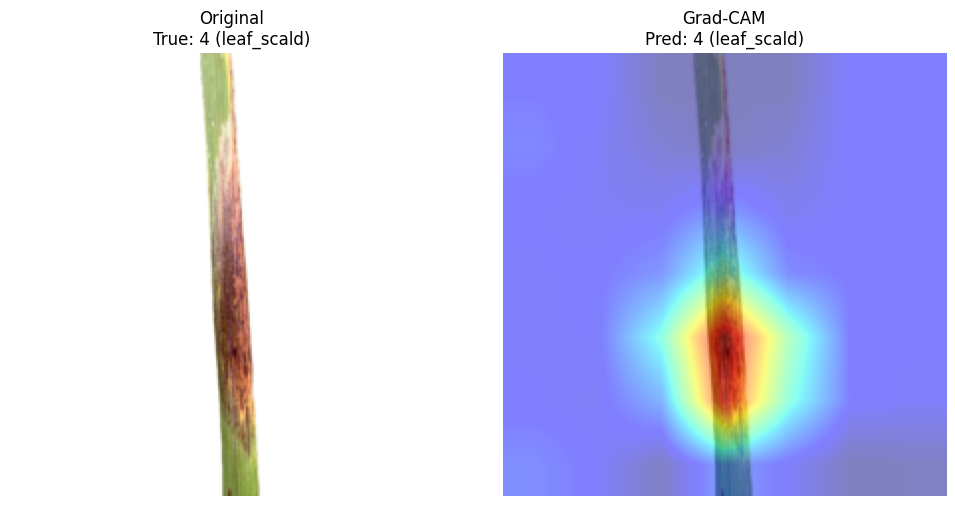

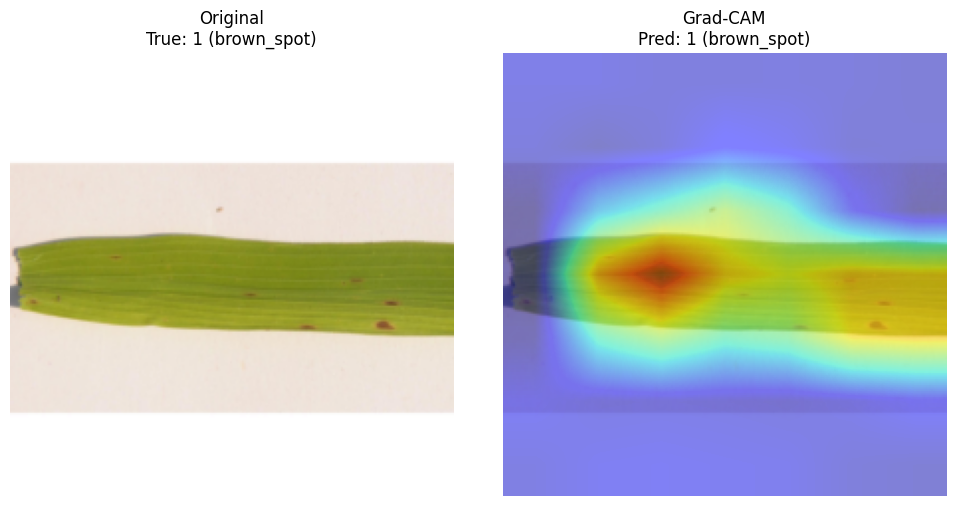

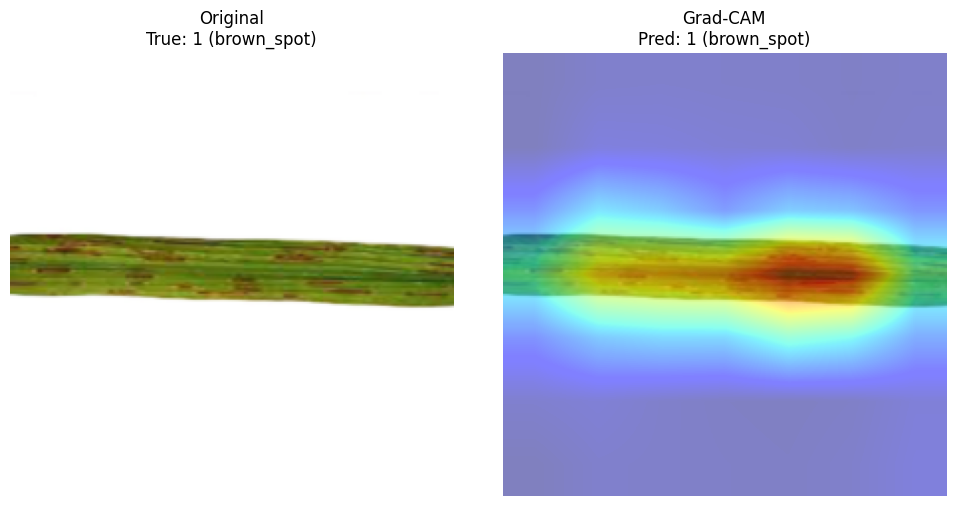

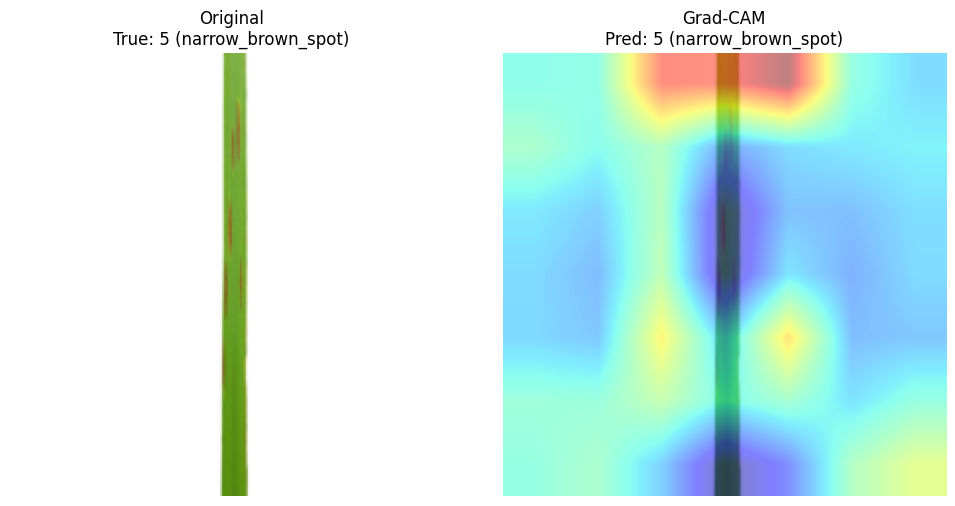

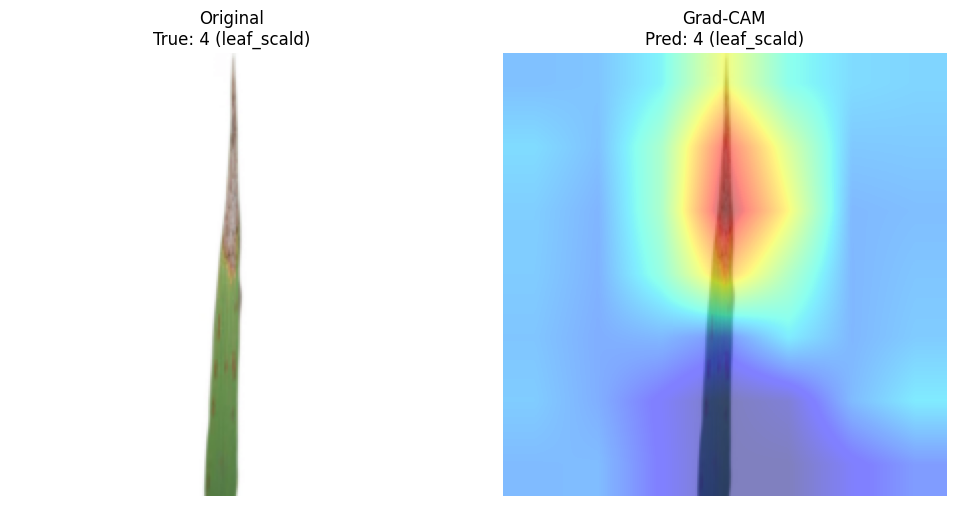

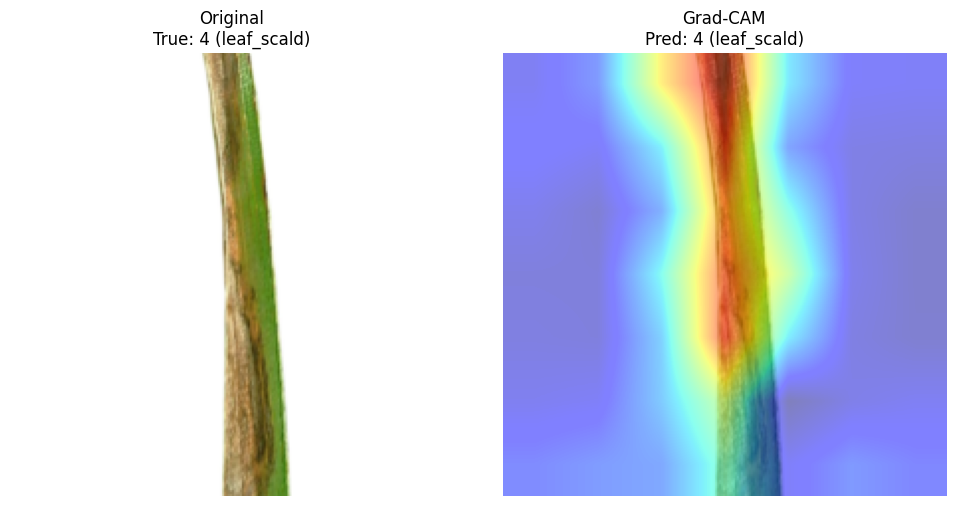

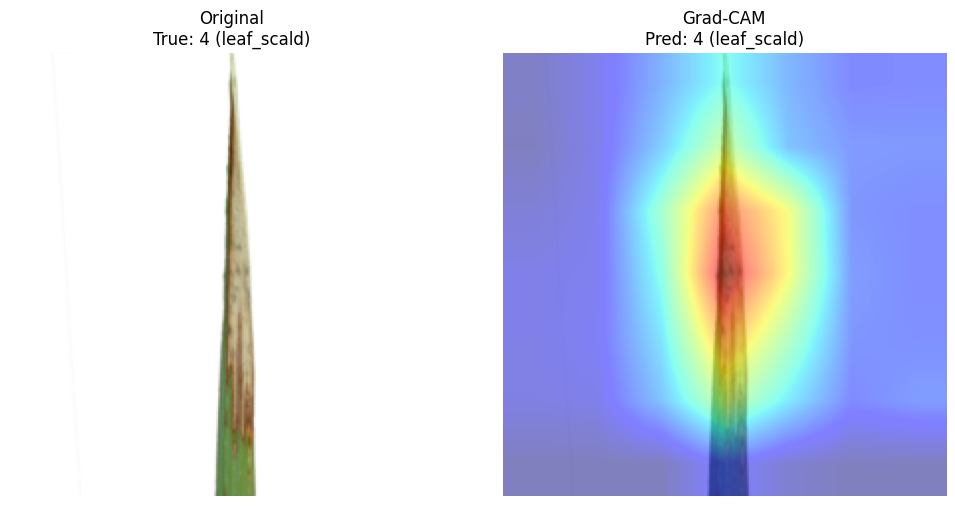

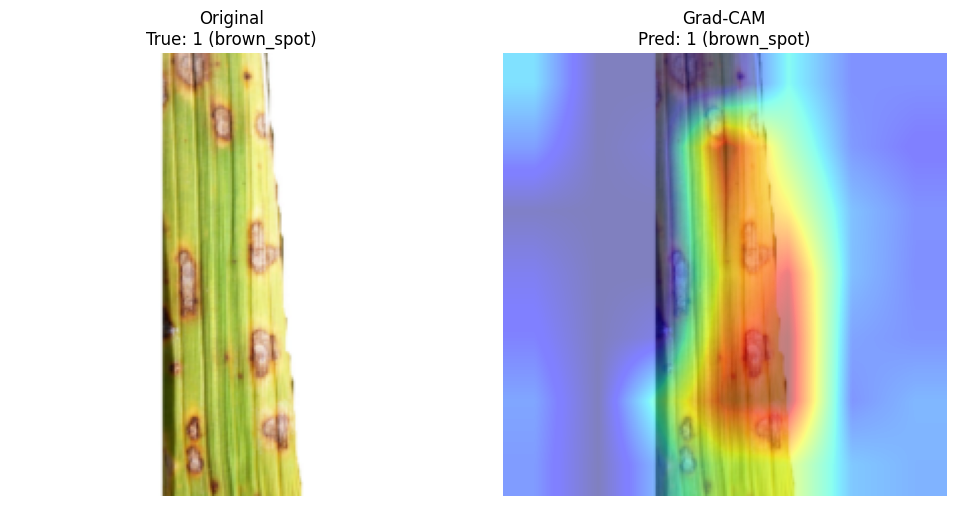

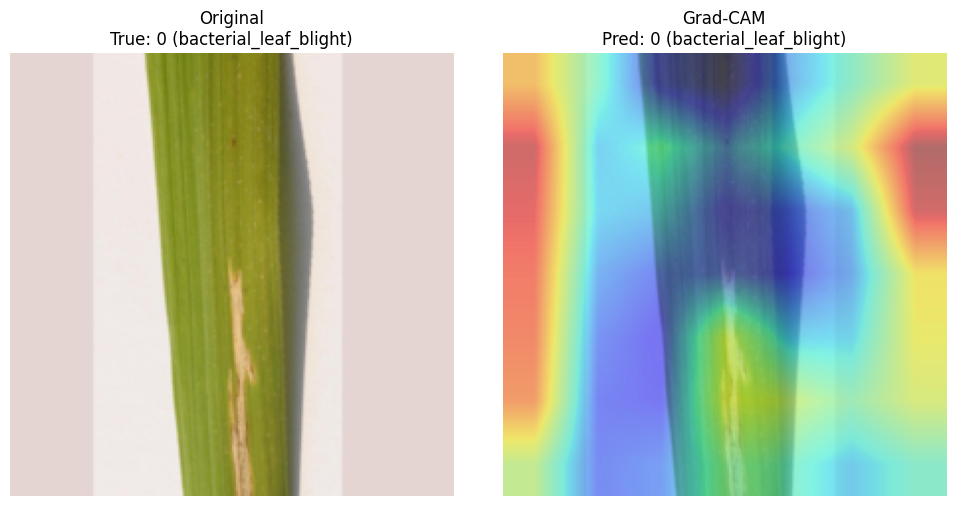

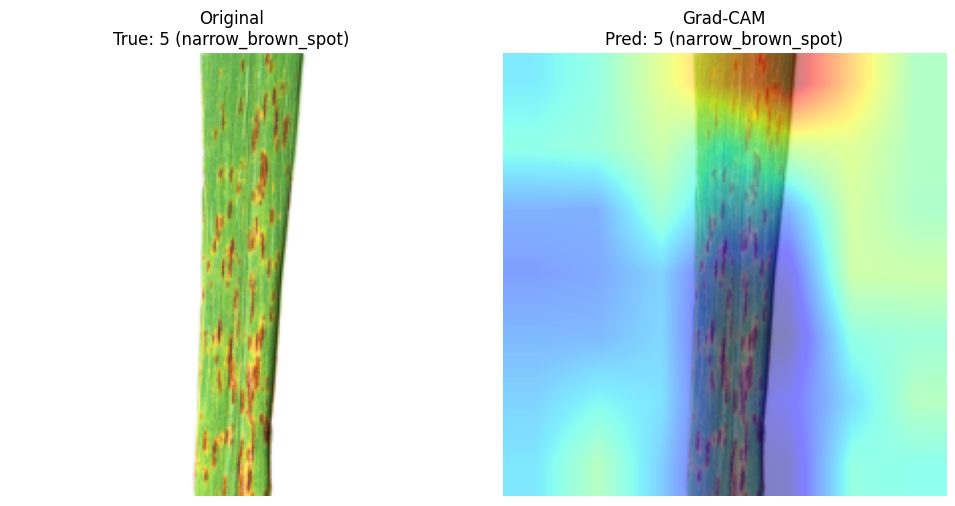

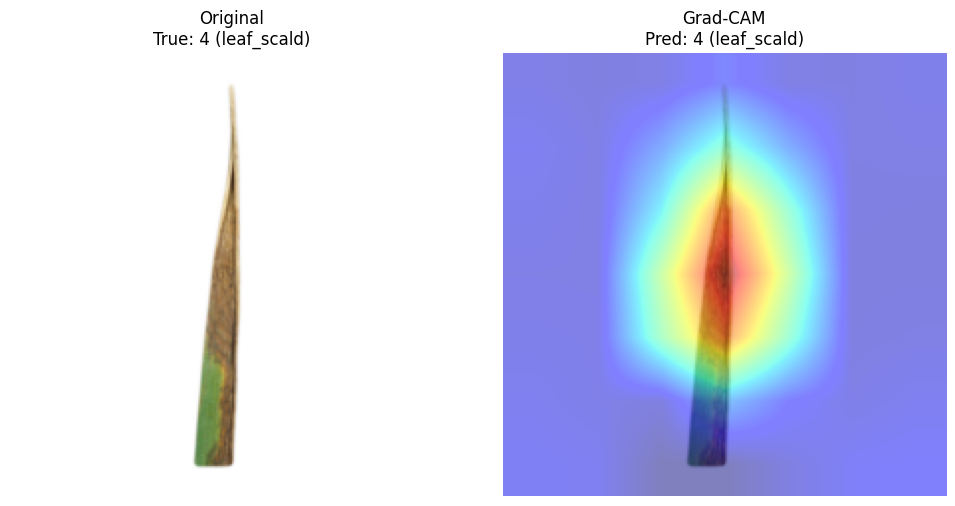

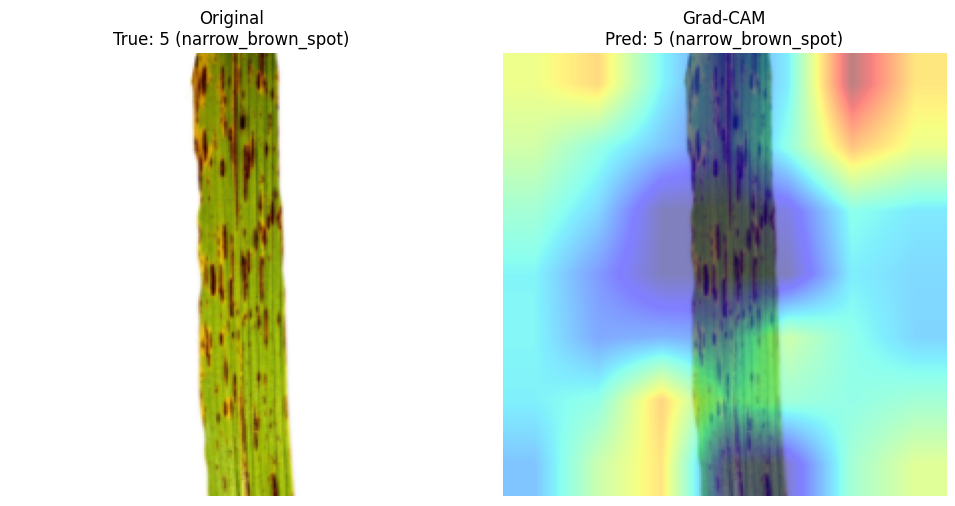

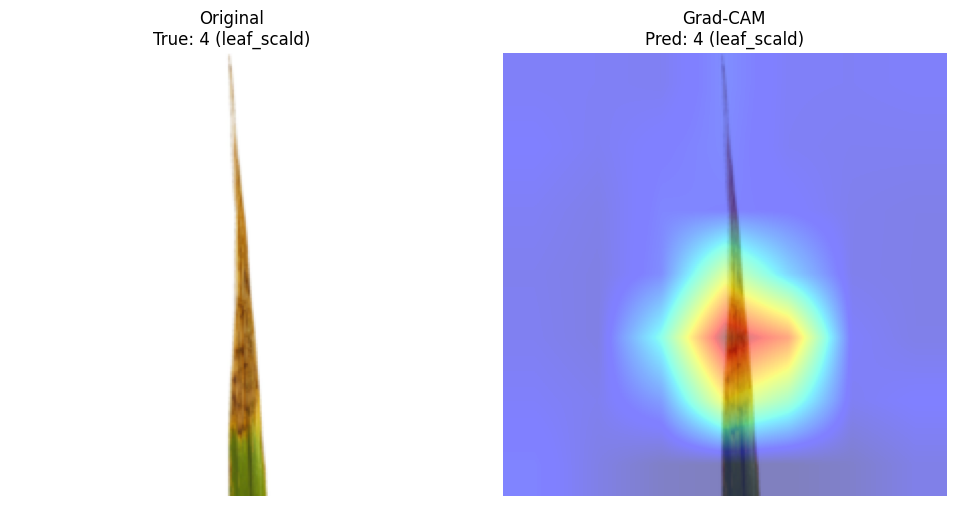

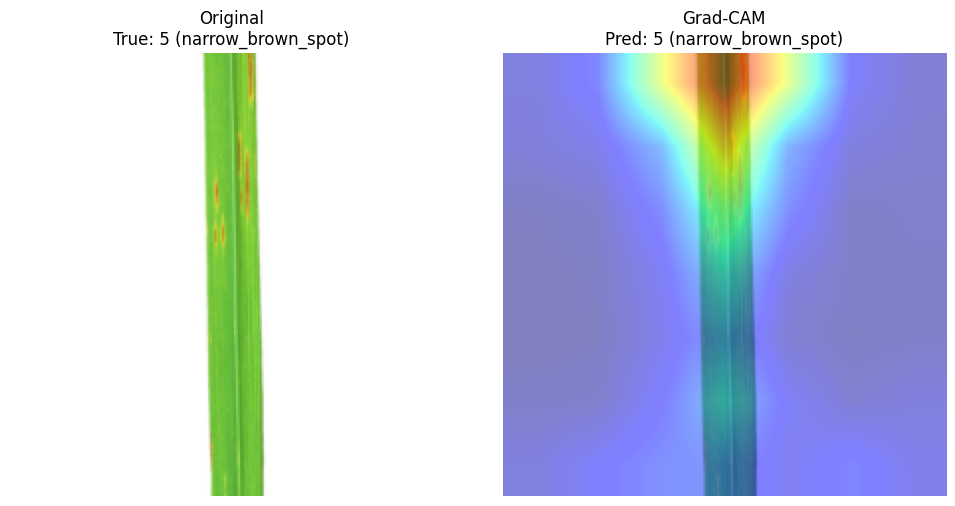

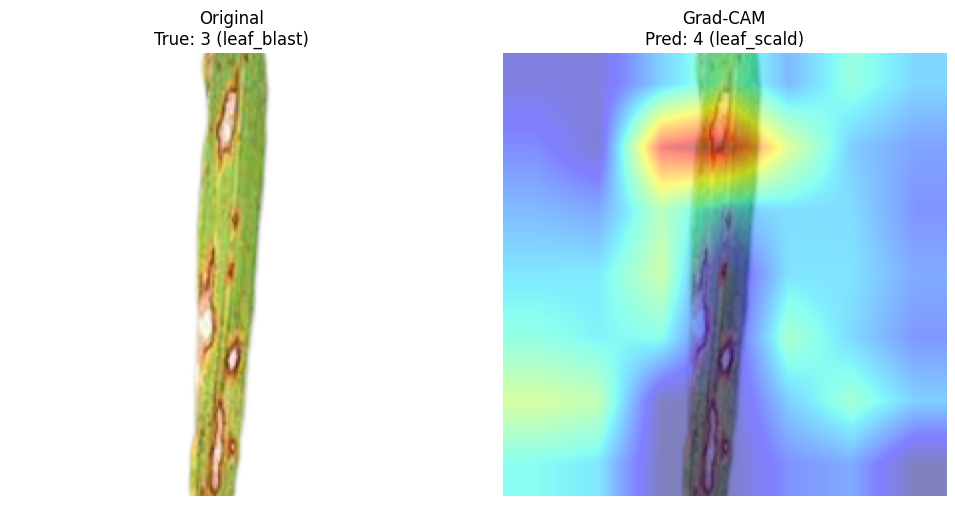

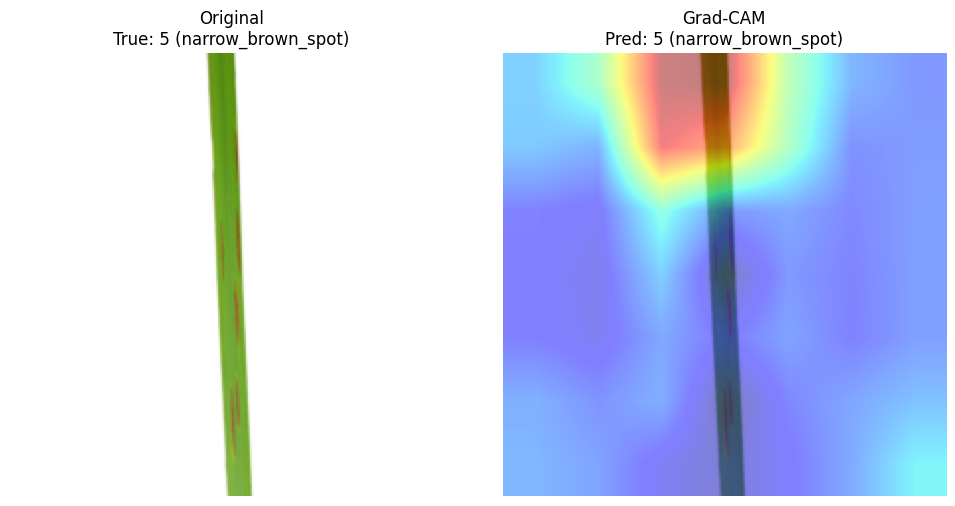

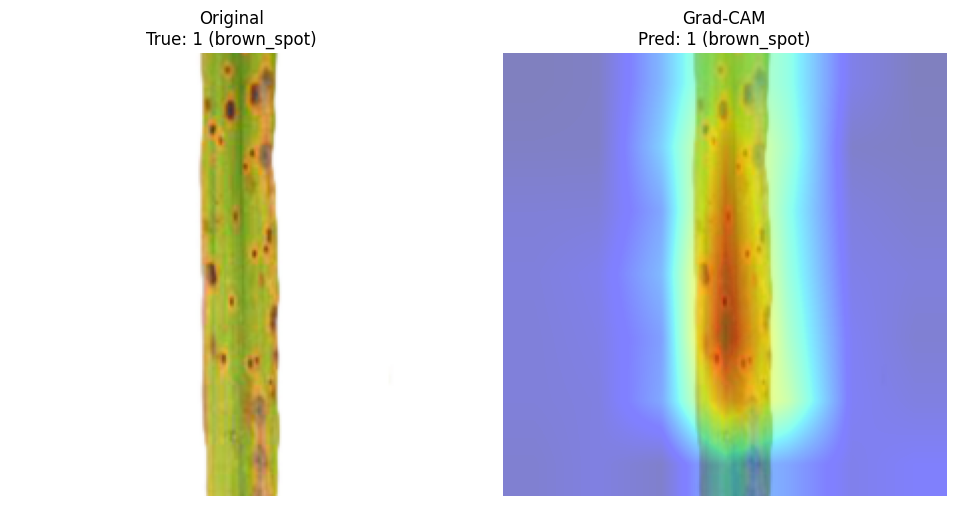

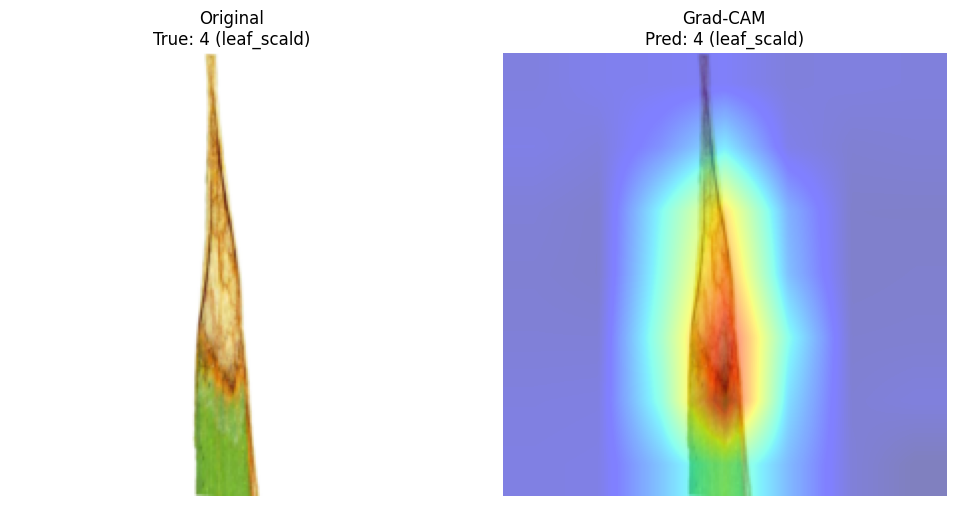

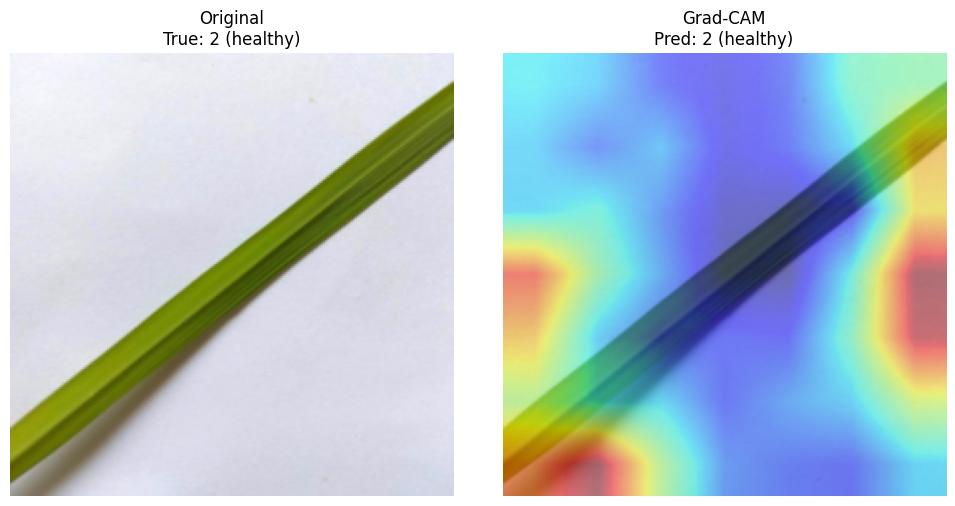

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# -------------------------
# Label mapping
# -------------------------
# Map class indices to class names (folder names)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# -------------------------
# Number of samples to visualize
# -------------------------
num_images = 20
random_indices = random.sample(range(len(val_dataset)), num_images)

# -------------------------
# Set model to evaluation mode
# -------------------------
model.eval()

# -------------------------
# Loop through selected validation images
# -------------------------
for idx in random_indices:
    img, true_label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Grad-CAM extraction
    activation_map = cam_extractor(pred_class, output)[0]  # shape: (1, H, W)
    cam = F.interpolate(activation_map.unsqueeze(0), size=img.shape[1:], mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # Convert image for display
    # original_img = to_pil_image(img)
    img_denorm = denormalize(img).clamp(0, 1)
    original_img = to_pil_image(img_denorm)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {true_label} ({idx_to_class[true_label]})")
    axes[0].axis("off")

    # Grad-CAM overlay
    axes[1].imshow(original_img)
    axes[1].imshow(cam, cmap='jet', alpha=0.5)
    axes[1].set_title(f"Grad-CAM\nPred: {pred_class} ({idx_to_class[pred_class]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

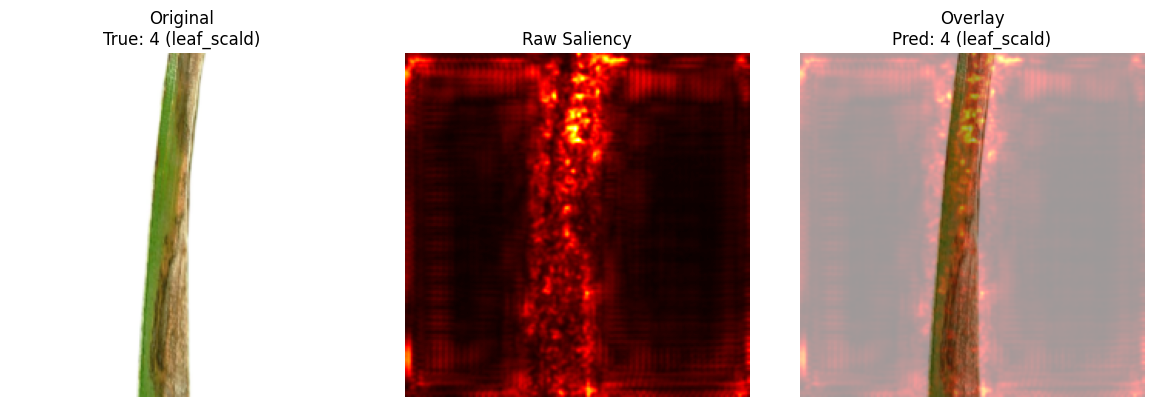

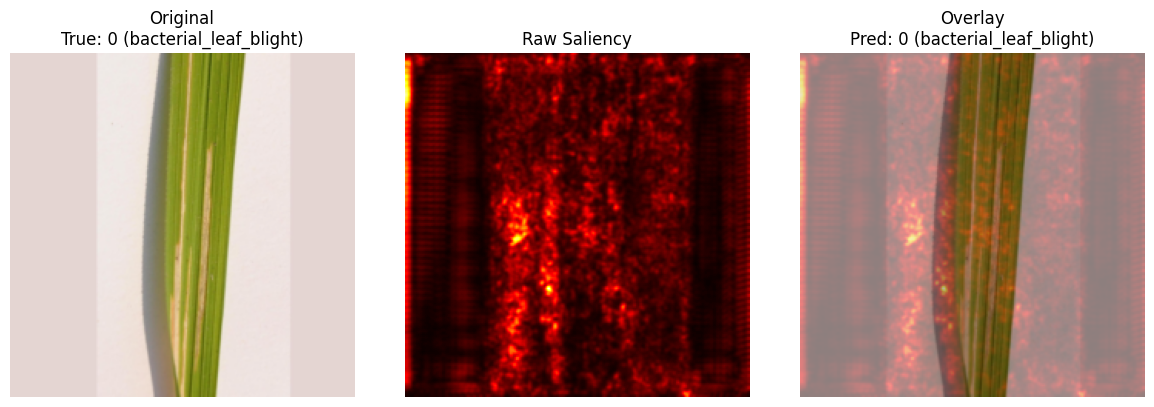

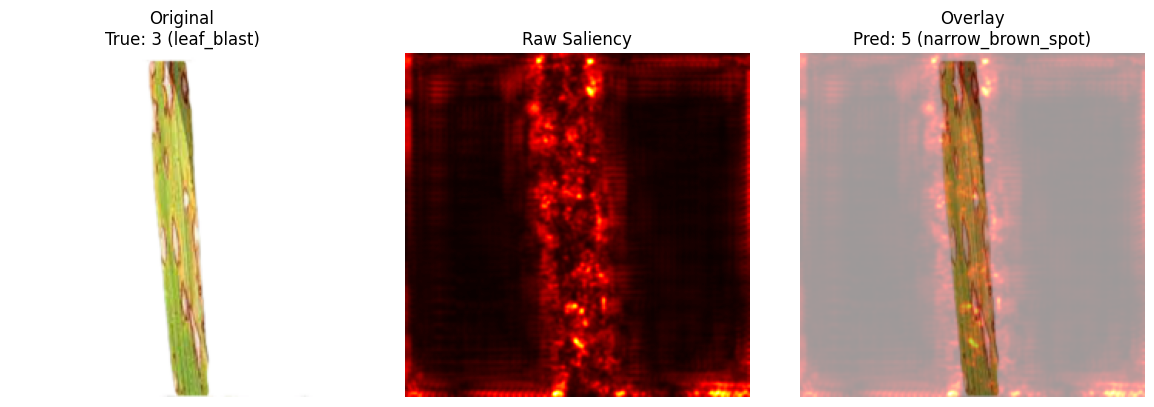

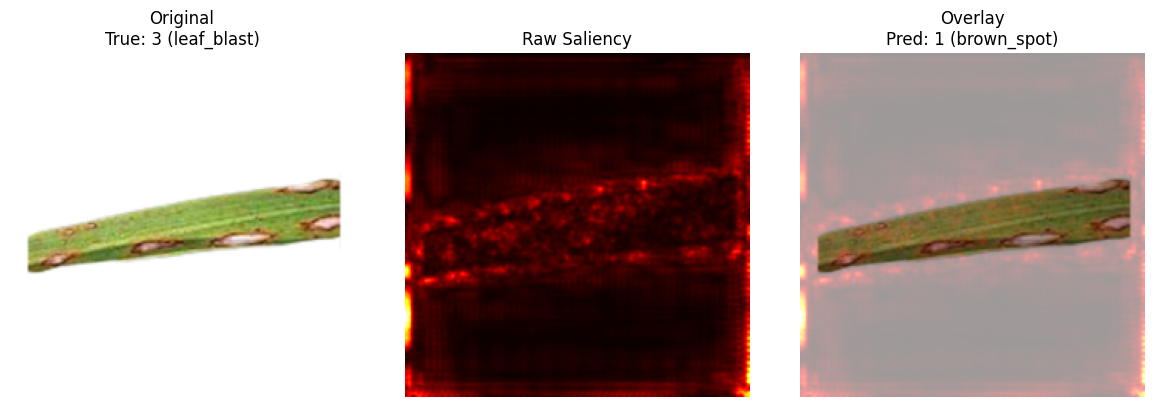

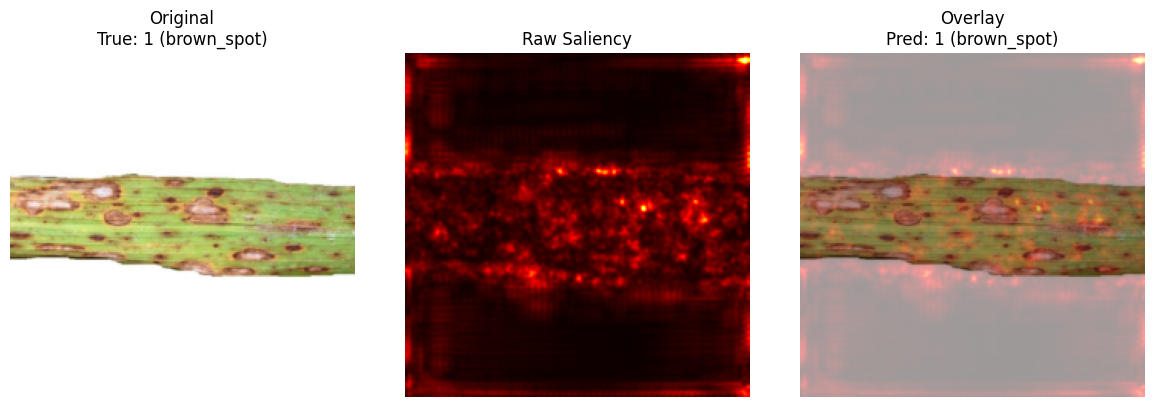

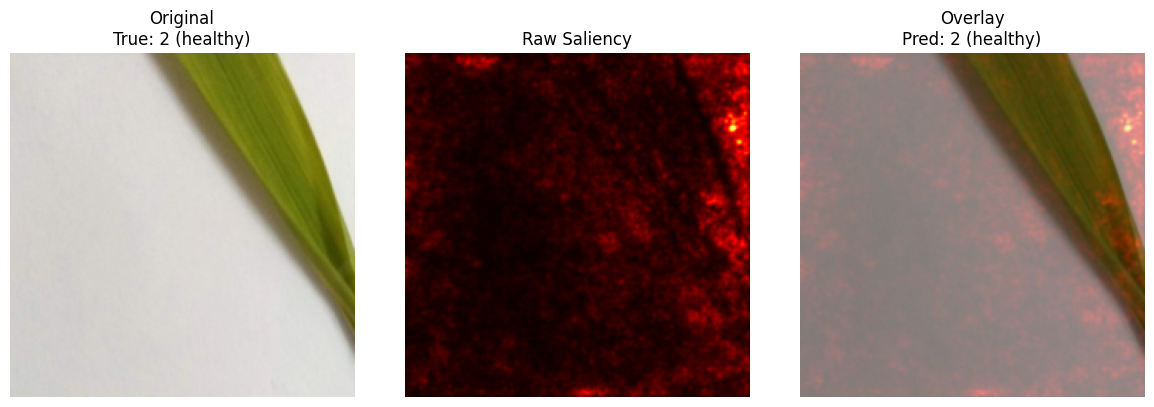

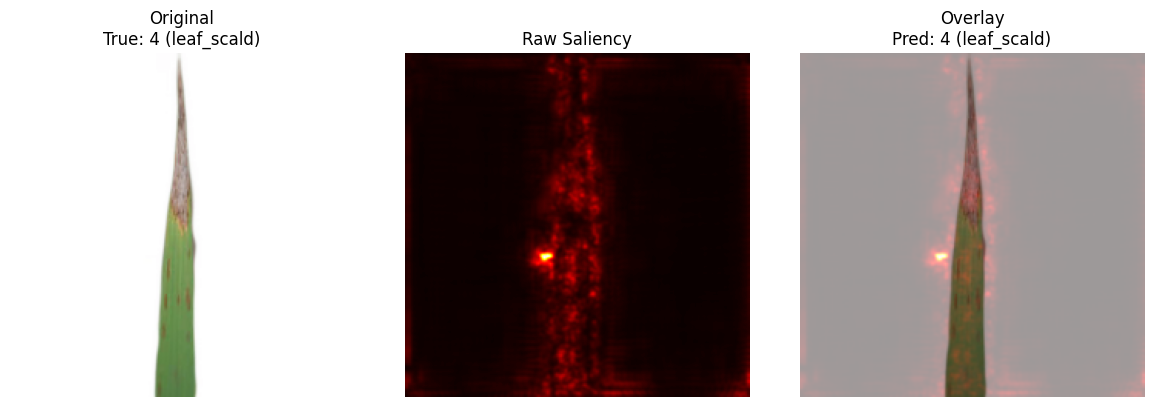

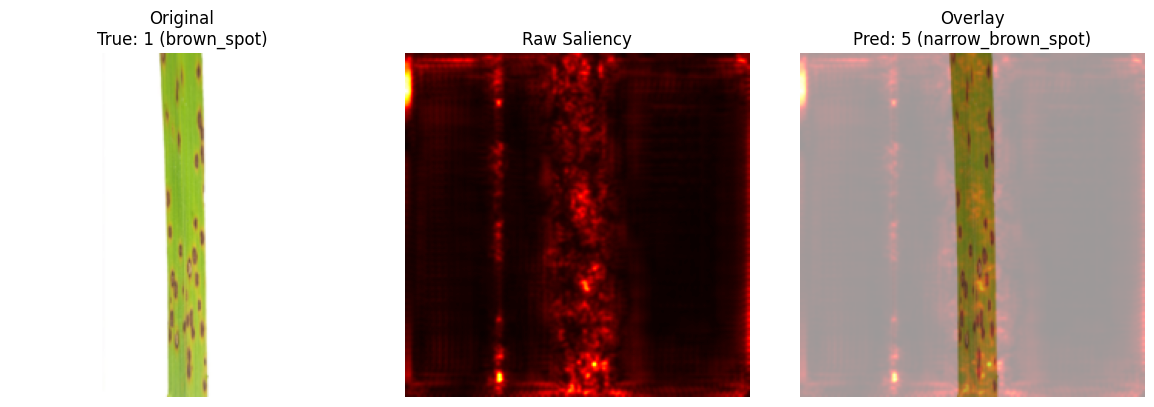

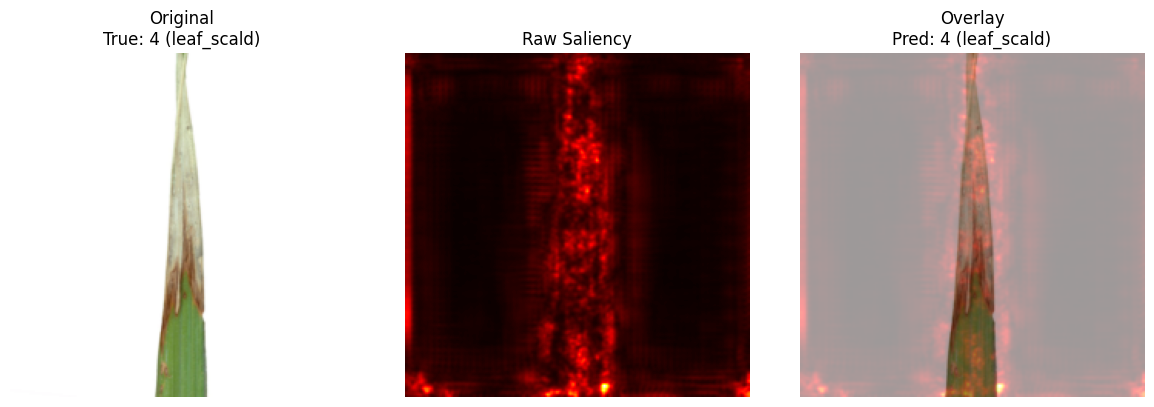

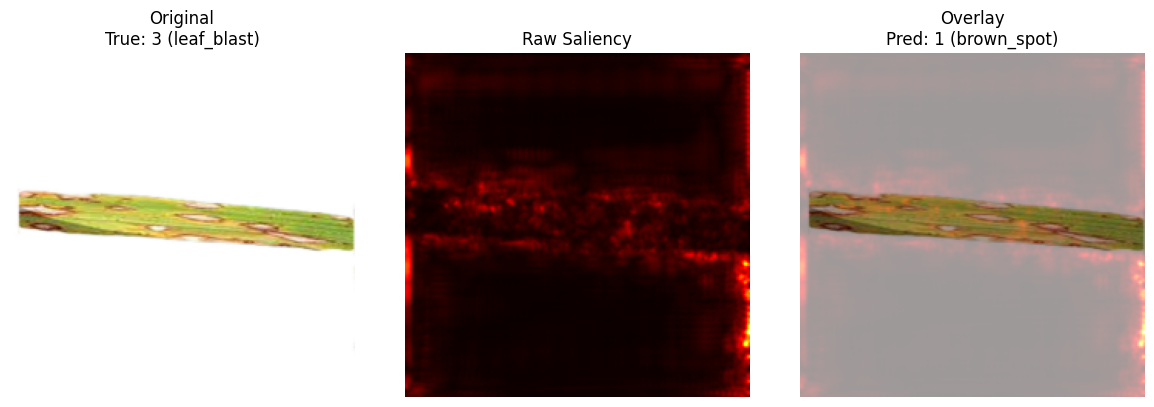

In [11]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from scipy.ndimage import gaussian_filter

model.eval()

indices = random.sample(range(len(val_dataset)), 10)

for idx in indices:
    img, label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax()

    # Backward on predicted class
    model.zero_grad()
    output[0, pred_class].backward()

    # Raw saliency map
    saliency = input_tensor.grad.data.abs().squeeze()
    saliency_map = saliency.max(dim=0)[0].cpu().numpy()

    # Optional Gaussian smoothing
    saliency_map = gaussian_filter(saliency_map, sigma=1)

    # Normalize saliency
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()

    # Convert original image
    img_tensor = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    original_img = to_pil_image(img_tensor)

    # Create heatmap
    heatmap = plt.get_cmap("hot")(saliency_map)[:, :, :3]  # Remove alpha
    heatmap_tensor = torch.tensor(heatmap).permute(2, 0, 1)

    # Overlay
    overlay = 0.6 * img_tensor + 0.4 * heatmap_tensor
    overlay = torch.clamp(overlay, 0, 1)

    # Plot all three
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {label} ({train_dataset.classes[label]})")
    axes[0].axis("off")

    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Raw Saliency")
    axes[1].axis("off")

    axes[2].imshow(to_pil_image(overlay))
    axes[2].set_title(f"Overlay\nPred: {pred_class.item()} ({train_dataset.classes[pred_class.item()]})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
